# FASHION RECOMMENDER SYSTEM / CONTENT-BASED FILTERING

## 1. Importing Libraries and Data

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# # Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
import warnings
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read the CSV file

df_articles = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv')
df_articles.head()
df_articles.shape

#(105542, 25)

(105542, 25)

In [3]:
# Selecting the ones with 'ladies wear' from the 'index_group_name'

df_ladies = df_articles[df_articles['index_group_name'] == 'Ladieswear']
df_ladies = df_ladies.reset_index(drop=True)
df_ladies.shape
df_ladies.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


## 2. Data Preprocessing

In [4]:
# Identifying missing values

df_ladies.isnull().any()
missing_count = df_ladies['detail_desc'].isnull().sum()
print(missing_count)

214


In [5]:
# Removing missing data

df_ladies = df_ladies.dropna(subset=['detail_desc'])
df_ladies = df_ladies.reset_index(drop=True)
df_ladies.shape

(39523, 25)

In [6]:
# Total number of products in each product group

df_ladies['product_group_name'].value_counts()

Garment Upper body       14062
Garment Lower body        5720
Garment Full body         5582
Accessories               5202
Underwear                 3692
Shoes                     2026
Swimwear                  1899
Nightwear                  663
Socks & Tights             577
Unknown                     56
Items                       16
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Bags                         1
Name: product_group_name, dtype: int64

In [7]:
# Determining the data type of columns

df_ladies.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [8]:
# Preparation for TF-IDF matrix

df = df_ladies.select_dtypes(include=['object'])
df.head()

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_code,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [9]:
# Concatenate all text columns to create a document collection

documents = df.apply(' '.join, axis=1)
print(documents)

0        Strap top Vest top Garment Upper body Solid Bl...
1        Strap top Vest top Garment Upper body Solid Wh...
2        Strap top (1) Vest top Garment Upper body Stri...
3        OP T-shirt (Idro) Bra Underwear Solid Black Da...
4        OP T-shirt (Idro) Bra Underwear Solid White Li...
                               ...                        
39518    Jets dress Dress Garment Full body All over pa...
39519    Elton top Top Garment Upper body All over patt...
39520    SPORT Malaga tank Vest top Garment Upper body ...
39521    Cartwheel dress Dress Garment Full body Solid ...
39522    Lounge dress Dress Garment Full body Solid Off...
Length: 39523, dtype: object


In [10]:
# Preprocessing for TF-IDF vectors

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stopwords.words('english')]
    return " ".join(filtered_tokens)

documents = documents.apply(preprocess_text)
print(documents)

0        strap top vest top garment upper body solid bl...
1        strap top vest top garment upper body solid wh...
2        strap top 1 vest top garment upper body stripe...
3        op shirt idro bra underwear solid black dark b...
4        op shirt idro bra underwear solid white light ...
                               ...                        
39518    jets dress dress garment full body pattern bei...
39519    elton top top garment upper body pattern beige...
39520    sport malaga tank vest top garment upper body ...
39521    cartwheel dress dress garment full body solid ...
39522    lounge dress dress garment full body solid whi...
Length: 39523, dtype: object


## 3. TF-IDF Vectorization

In [11]:
# TF-IDF vectorization

tfidf = TfidfVectorizer()

In [12]:
# Convert the document collection to TF-IDF vectors

tfidf_matrix = tfidf.fit_transform(documents)
print(tfidf_matrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
# Examining the TF-IDF matrix

tfidf_matrix.shape
tfidf.get_feature_names_out()

array(['10', '100', '100den', ..., 'zwem', 'örhängen', 'ﬁbres'],
      dtype=object)

## 4. Cosine Similarity Calculation

In [14]:
# Calculating the similarity between TF-IDF vectors of documents using the cosine similarity metric

cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [15]:
# Examining the cosine similarity metric

cosine_sim.shape
cosine_sim[1]

array([0.89164508, 1.        , 0.96253901, ..., 0.2591762 , 0.17425709,
       0.26238358])

## 5. Content-Based Recommender Function

In [16]:
def content_based_recommender(article_id, cosine_sim, dataframe):
    indices = pd.Series(dataframe.index, index=dataframe['article_id'])
    indices = indices[~indices.index.duplicated(keep='last')]
    product_index = indices[article_id]
    similarity_scores = pd.DataFrame(cosine_sim[product_index], columns=["score"])
    product_indices = similarity_scores.sort_values("score", ascending=False).index[1:6]

    return dataframe['article_id'].iloc[product_indices]

In [17]:
# The code snippet that generates recommendations for a random article using your content-based recommender

main_article_id = np.random.choice(df_ladies['article_id'])

print(main_article_id)

775977001


In [18]:
recommended_articles = content_based_recommender(main_article_id, cosine_sim, df_ladies)

print(recommended_articles)

23633    756111001
25845    775977002
6121     577399004
6120     577399001
5397     568838001
Name: article_id, dtype: int64


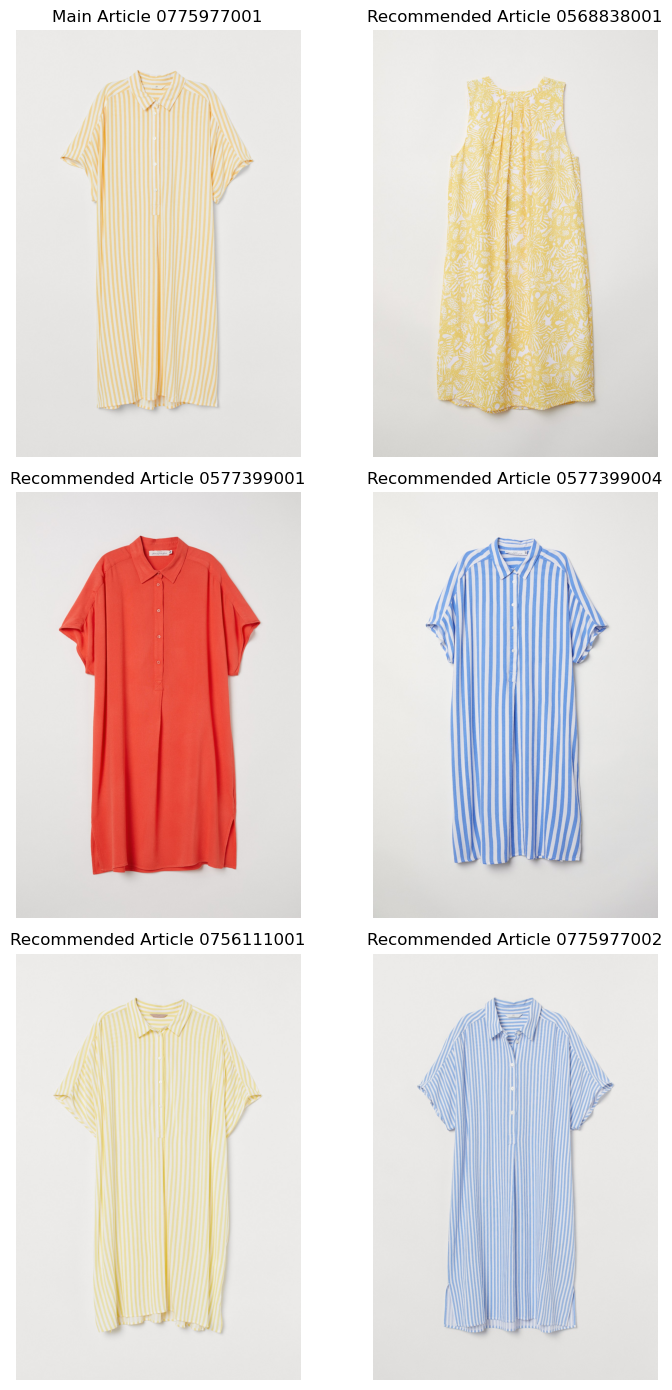

In [19]:
# Display recommended products and their images

image_path = "../input/h-and-m-personalized-fashion-recommendations"

cols = 2
rows = (len(recommended_articles) + cols - 1) // cols

_df = df_ladies[df_ladies['article_id'].isin(recommended_articles)]
article_ids = _df.article_id.values[0:cols*rows]

plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    
    if i == 0:
        article_id = ("0" + str(main_article_id))[-10:]
        plt.title(f"Main Article {article_id}")
    else:
        article_id = ("0" + str(article_ids[i-1]))[-10:]
        plt.title(f"Recommended Article {article_id}")
    
    image = Image.open(f"{image_path}/images/{article_id[:3]}/{article_id}.jpg")
    plt.imshow(image)

plt.tight_layout()
plt.show()
